Author: Nelson Liu

Email: [nliu@uncharted.software](mailto:nliu@uncharted.software)

# Multi-Stratify Experiment

Construct a `n`-stratified model in Petri-net representation using AlgebraicJulia, following the code developed during the January 2023 DARPA-ASKEM Hackathon.

Source: [https://github.com/DARPA-ASKEM/program-milestones/blob/main/6-month-milestone/evaluation/scenario_1/ta_2/scenario1_stratify_v3.ipynb](https://github.com/DARPA-ASKEM/program-milestones/blob/main/6-month-milestone/evaluation/scenario_1/ta_2/scenario1_stratify_v3.ipynb)

In [33]:
# Libraries
using AlgebraicPetri, AlgebraicPetri.TypedPetri
using Catlab.Programs, Catlab.Graphics
using Catlab.CategoricalAlgebra
using GraphViz

## Define Ontology

`infect` interaction: two `Pop` converts into another two `Pop` (e.g. infection of one agent by another agent)

`disease` interaction: one `Pop` converts to another `Pop` (e.g. recovery from infection)

`strata` interaction: one `Pop` converts to another `Pop` (e.g. unvaccinated to vaccinated)

In [34]:
const infectious_ontology = LabelledPetriNet(
    [:Pop],
    :infect => ((:Pop, :Pop) => (:Pop, :Pop)),
    :disease => (:Pop => :Pop),
    :strata => (:Pop => :Pop)
)

#Graph(infectious_ontology)
to_graphviz(infectious_ontology)

LoadError: MethodError: no method matching to_graphviz(::LabelledPetriNet)
[0mClosest candidates are:
[0m  to_graphviz([91m::Catlab.WiringDiagrams.DirectedWiringDiagrams.WiringDiagram[39m; graph_name, orientation, node_labels, labels, label_attr, port_size, junction_size, outer_ports, anchor_outer_ports, graph_attrs, node_attrs, title, node_colors, edge_attrs, cell_attrs) at ~/.julia/packages/Catlab/87RDU/src/graphics/GraphvizWiringDiagrams.jl:81
[0m  to_graphviz([91m::Subobject{<:Catlab.Graphs.BasicGraphs.HasGraph}[39m; kw...) at ~/.julia/packages/Catlab/87RDU/src/graphics/GraphvizGraphs.jl:316
[0m  to_graphviz([91m::Catlab.WiringDiagrams.UndirectedWiringDiagrams.AbstractUWD[39m; kw...) at ~/.julia/packages/Catlab/87RDU/src/graphics/GraphvizWiringDiagrams.jl:408
[0m  ...

## Define Disease Model

Basic SIR disease model:
* `infect` interaction (infection of S by I)
* `disease` interaction (recovery of I to R)

Steps:
1. Start as an undirected wiring diagram (UWD)
2. Apply typing from the ontology
3. Define transition parameter names (`beta`, `gamma`)

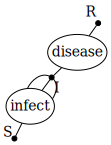

In [35]:
sir_uwd = @relation () where (S::Pop, I::Pop, R::Pop) begin
    infect(S, I, I, I)
    disease(I, R)
end

to_graphviz(sir_uwd, box_labels = :name, junction_labels = :variable)

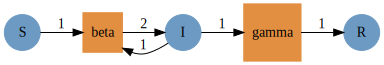

In [36]:
tnames = [:beta, :gamma]
typed_sir = oapply_typed(infectious_ontology, sir_uwd, tnames)
Graph(dom(typed_sir))

## Define Age-Group Contact Model

`N` age groups

Assume a contact model that is a fully connected pairwise graph with identity; 
i.e. every age group `:Pop` can infect every other age group `:Pop`, including self.

Note: the definition of `pairwise_id_typed_petri` is in [https://github.com/AlgebraicJulia/AlgebraicPetri.jl/blob/master/src/TypedPetri.jl](https://github.com/AlgebraicJulia/AlgebraicPetri.jl/blob/master/src/TypedPetri.jl)

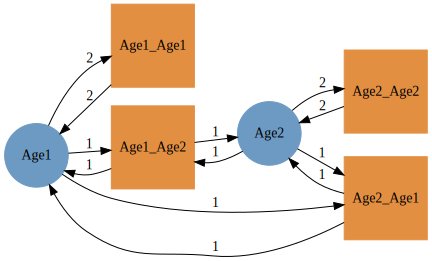

In [37]:
N = 2
snames = [Symbol("Age$i") for i in 1:N]

typed_age = pairwise_id_typed_petri(infectious_ontology, :Pop, :infect, snames)

Graph(dom(typed_age))

## Do Stratification as Petri Net Product

Stratification ~ product of two Petri-net models

Before applying the stratification operation, it is necessary to augment the base Petri nets with reflexives (self-to-self transitions)

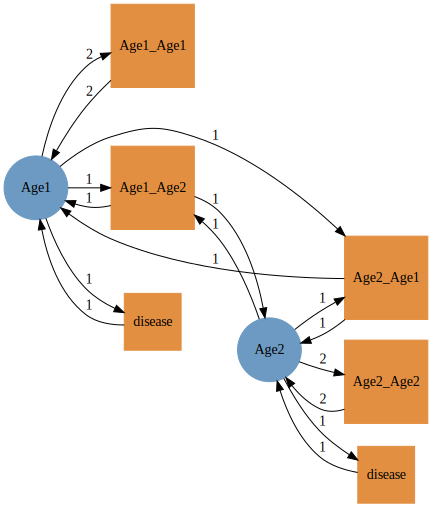

In [38]:
typed_age_aug = add_reflexives(
    typed_age,
    repeat([[:disease]], N),
    infectious_ontology
)

Graph(dom(typed_age_aug))

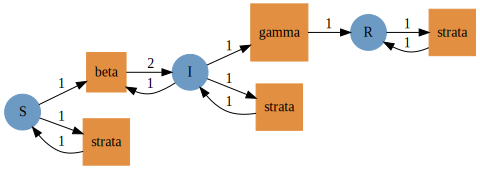

In [39]:
typed_sir_aug = add_reflexives(
    typed_sir,
    [[:strata], [:strata], [:strata]],
    infectious_ontology
)

Graph(dom(typed_sir_aug))

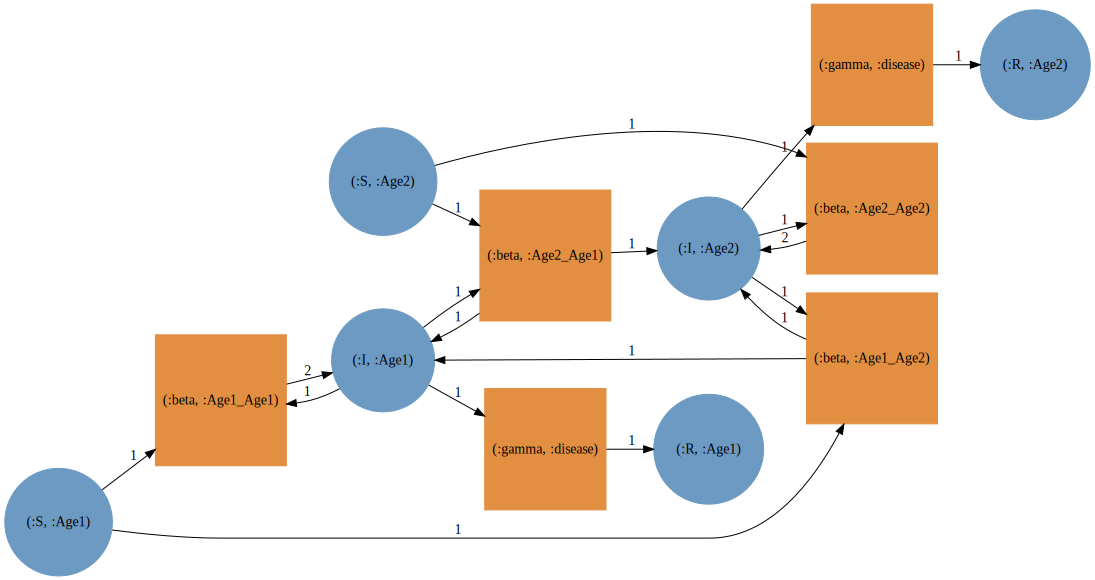

In [40]:
typed_sir_age = typed_product(typed_sir_aug, typed_age_aug)

Graph(dom(typed_sir_age))

## Repeat to Stratify International Travel Model

International travel ~ fully connected pairwise graph *without* identity since `:Pop` who do not travel just stay put.

Assume `M` countries

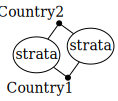

In [41]:
M = 2
snames = [Symbol("Country$i") for i in 1:M]

# Need a function like `pairwise_id_typed_petri` but without identity
travel_uwd = @relation () where (Country1::Pop, Country2::Pop) begin
    strata(Country1, Country2)
    strata(Country2, Country1)
end

to_graphviz(travel_uwd, box_labels = :name, junction_labels = :variable)

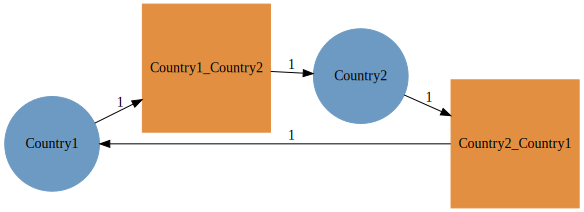

In [42]:
typed_travel = oapply_typed(infectious_ontology, travel_uwd, [:Country1_Country2, :Country2_Country1])

Graph(dom(typed_travel))

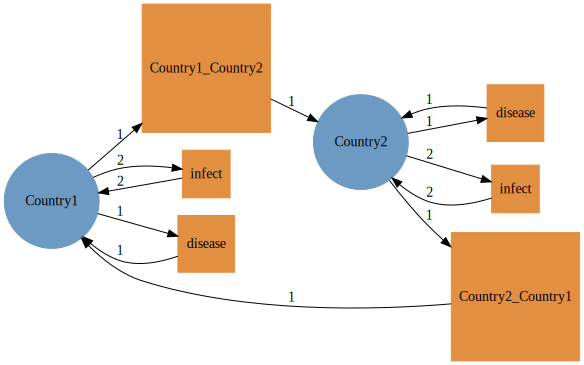

In [84]:
# Augment the travel model with reflexives

typed_travel_aug = add_reflexives(
    typed_travel,
    repeat([[:infect, :disease]], M),
    infectious_ontology
)

Graph(dom(typed_travel_aug))

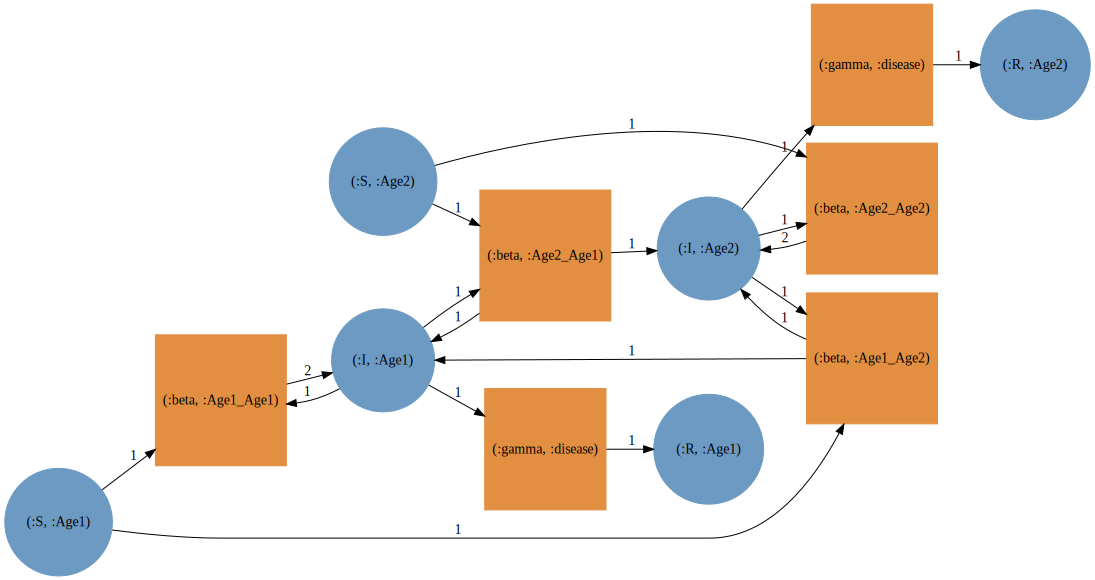

In [88]:
# Ditto for the previous SIR-Age model

# Note: cannot add reflexives of transition type `:strata`, problem caused by the Tuple(Symbol, Symbol) type of species nodes?

typed_sir_age_aug = add_reflexives(
    typed_sir_age,
    # repeat([:strata], 3 * N),
    [[], [], [], [], [], []],
    infectious_ontology
)

Graph(dom(typed_sir_age_aug))

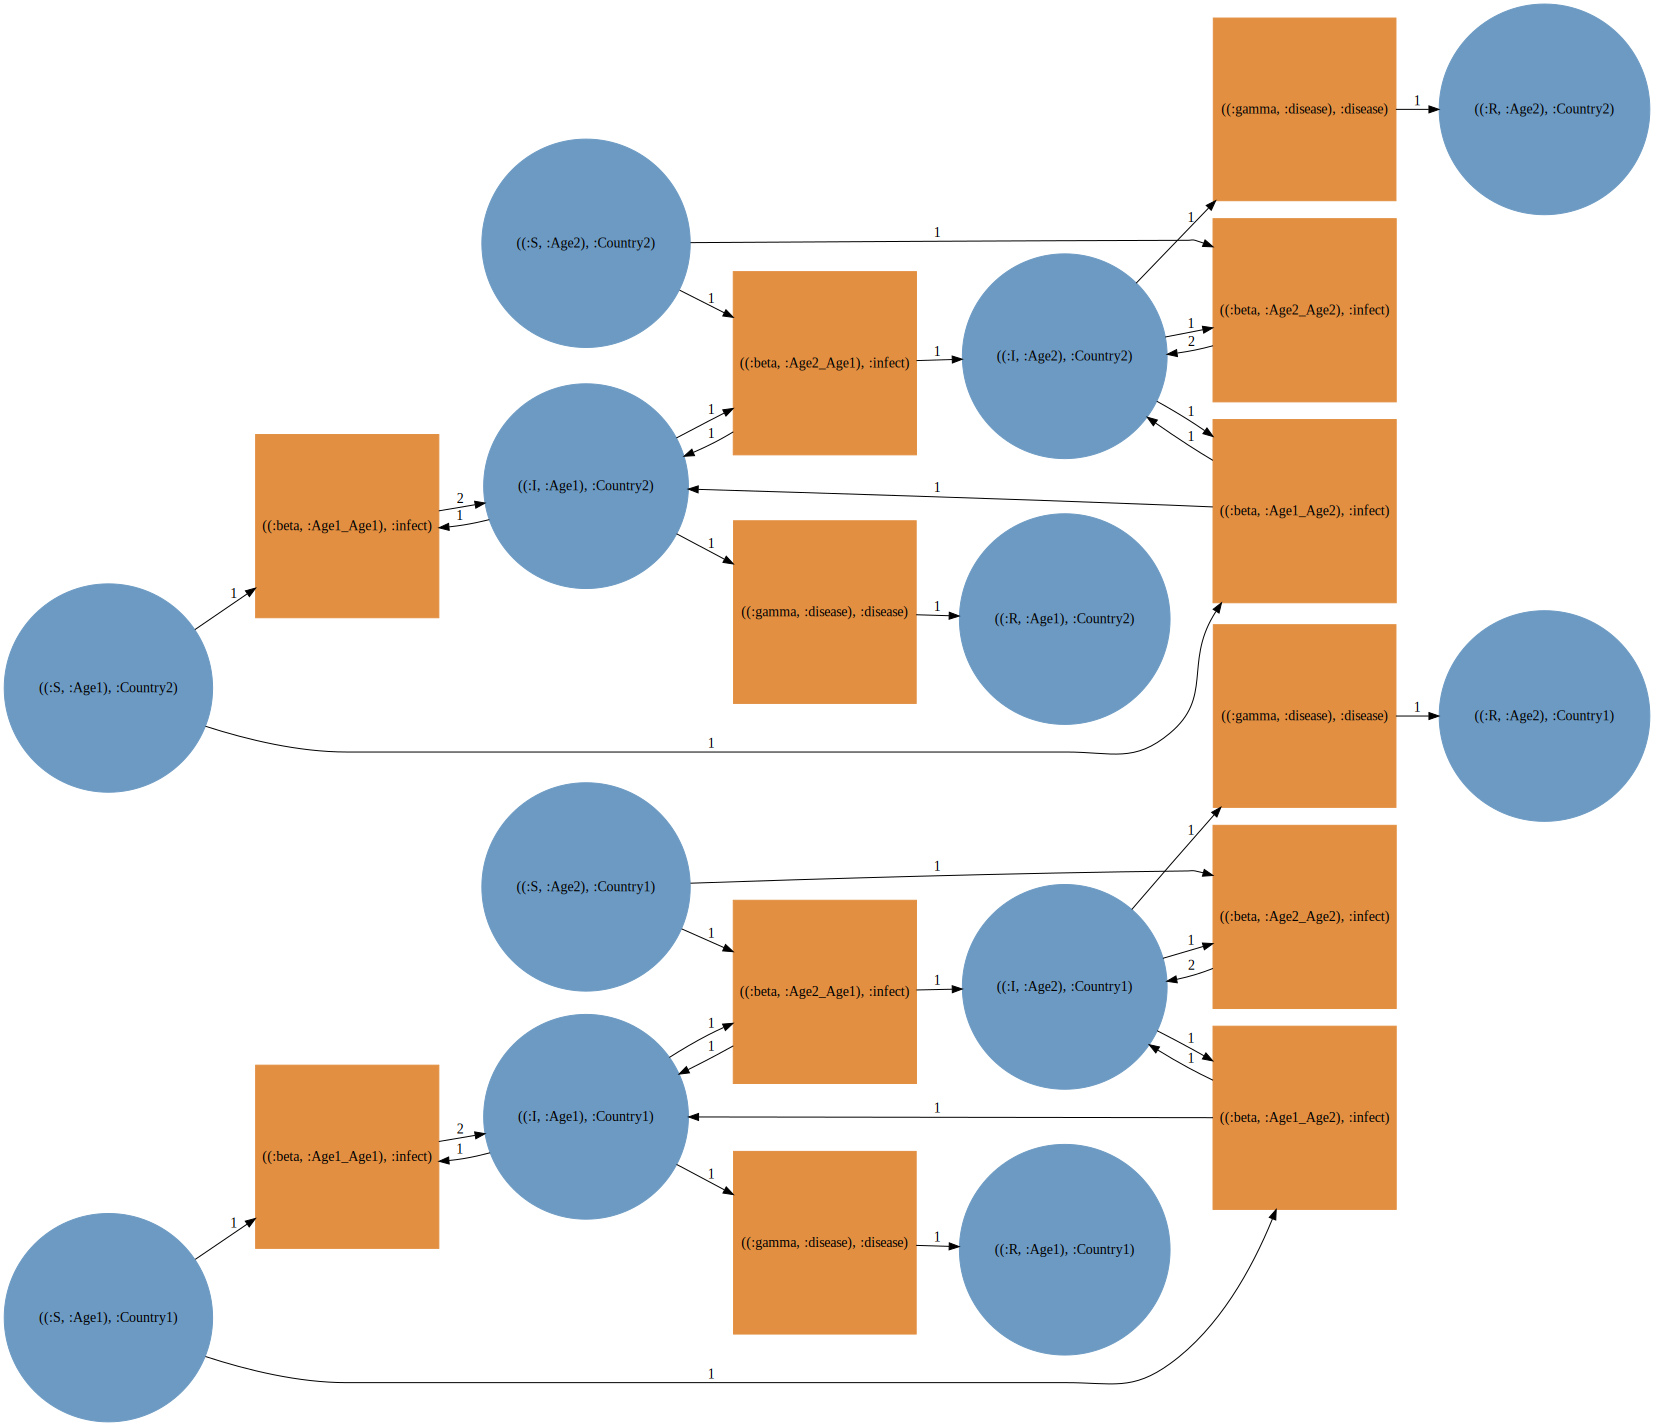

In [86]:
typed_sir_age_travel = typed_product(typed_sir_age_aug, typed_travel_aug)

Graph(dom(typed_sir_age_travel))

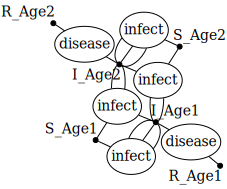

In [46]:
## Single-Stratification Method

# sir_age_nostrat_uwd = @relation () where (S_Age1::Pop, S_Age2::Pop, I_Age1::Pop, I_Age2::Pop, R_Age1::Pop, R_Age2::Pop) begin
sir_age_nostrat_uwd = @relation () where (S_Age1::Pop, I_Age1::Pop, S_Age2::Pop, I_Age2::Pop, R_Age1::Pop, R_Age2::Pop) begin
    infect(S_Age1, I_Age1, I_Age1, I_Age1)
    infect(S_Age2, I_Age2, I_Age2, I_Age2)
    infect(S_Age1, I_Age2, I_Age1, I_Age2)
    infect(S_Age2, I_Age1, I_Age2, I_Age1)
    disease(I_Age1, R_Age1)
    disease(I_Age2, R_Age2)
end

to_graphviz(sir_age_nostrat_uwd, box_labels = :name, junction_labels = :variable)

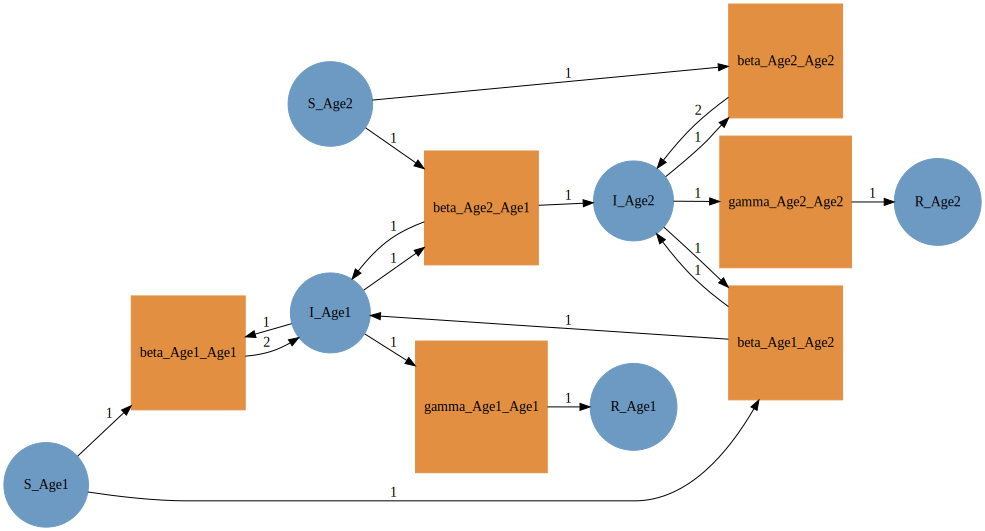

In [68]:
tnames = [:beta_Age1_Age1, :beta_Age2_Age2, :beta_Age1_Age2, :beta_Age2_Age1, :gamma_Age1_Age1, :gamma_Age2_Age2]
typed_sir_age_nostrat = oapply_typed(infectious_ontology, sir_age_nostrat_uwd, tnames)

Graph(dom(typed_sir_age_nostrat))

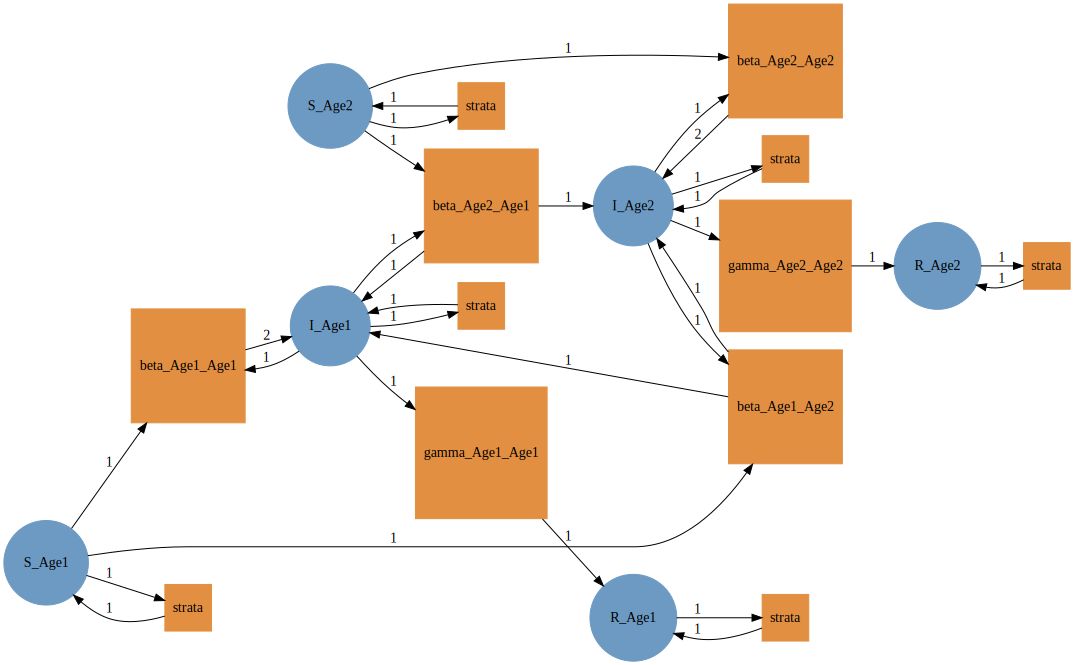

In [80]:
typed_sir_age_nostrat_aug = add_reflexives(
    typed_sir_age_nostrat,
    repeat([[:strata]], 6),
    infectious_ontology
)

Graph(dom(typed_sir_age_nostrat_aug))

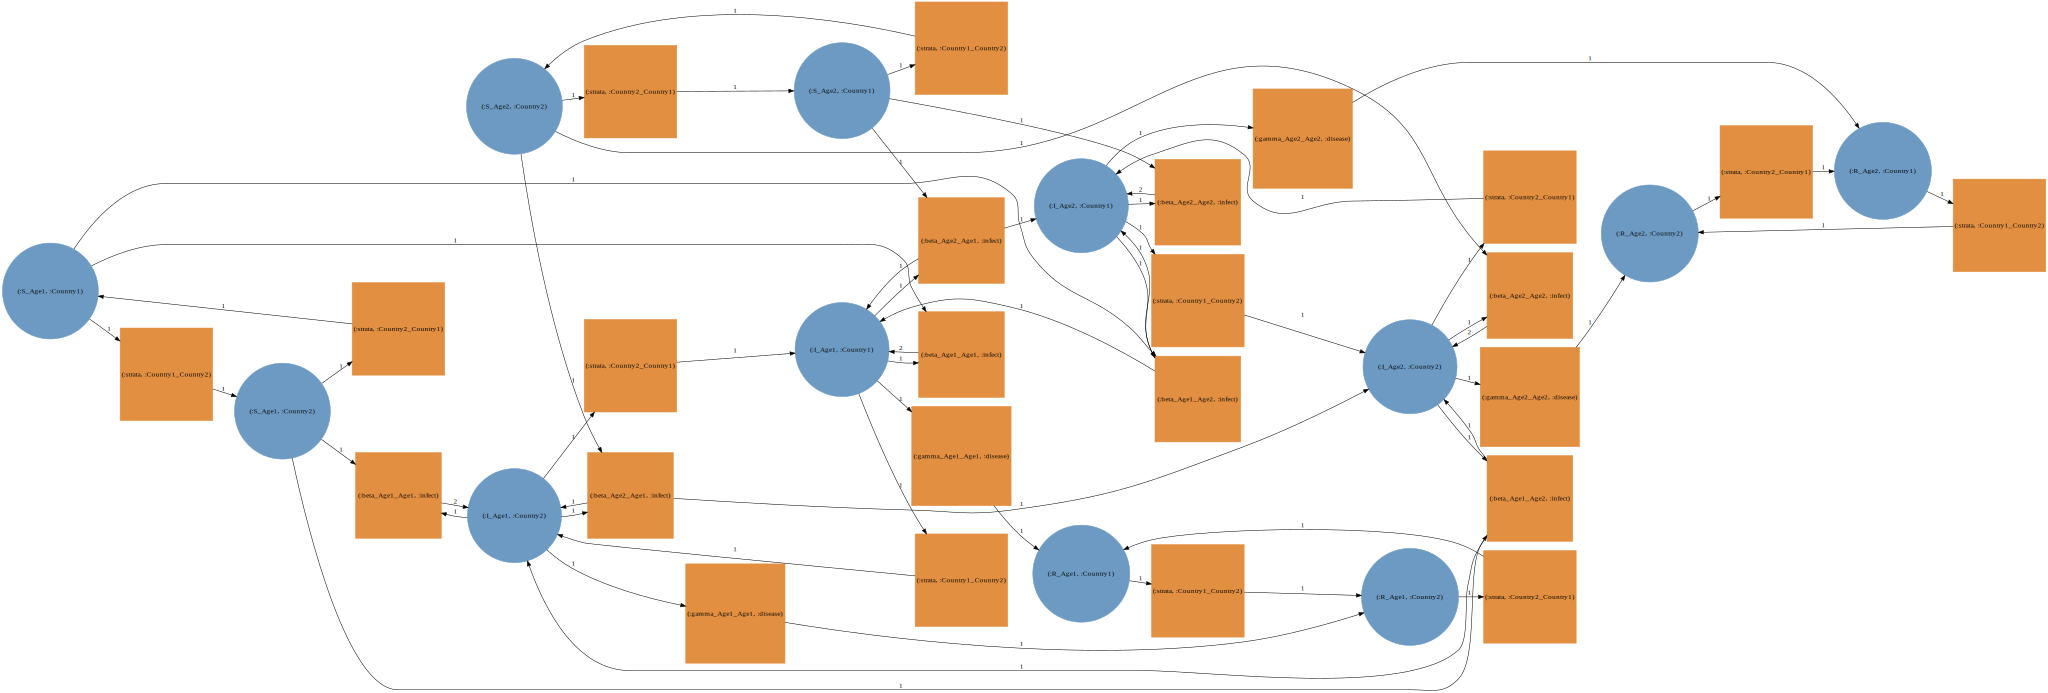

In [89]:
typed_sir_age_nostrat_travel = typed_product(typed_sir_age_nostrat_aug, typed_travel_aug)

Graph(dom(typed_sir_age_nostrat_travel))

^ Looks right for a doubly-stratified model `SIR_Age_Travel ~ ((SIR x Age) x Travel)`.

The key appears to be making sure that the Travel model has the reflexives `:infect, :disease`, enabling the `Country` populations can exhibit infectious and disease interactions.